# Debt Over Time

This notebook quickly explores how debt levels change over time in the extracted dataset.

As mentioned in the data quality notebook, a challenge with the extracted dataset is that text and html filings commonly report debt-levels in thousands or millions, whereas values obtained from xbrl submissions are often in unit dollar amounts.  This makes comparing debt-levels accross these filing submissions difficult.    Ideally, the application would be sophisticated enough to locate unit signifiers in the filings and perform applicable unit conversions.  Given the time constraints of the assignment, however, I decided this was out of scope.  For this purposes of this initial exploration one of two decisions can be made:

   1.  Leave the data as-is, and accept that large longitudinal changes in debt level may be an artifact of changing frequencies in filing types.
   2.  Perform some sort of ad-hoc scaling of the results to attempt rough parity between Text, HTML, and XBRL results.
    
Ultimately, for the purposes of evaluating population-level statistics of debt-levels over time, I elected to go with the second approach.  **In the results that follow final long and short term debt levels less than 10 thousand are multiplied by a factor of a thousand for text and html results.**  This is a crude adjustment and is something I'd certainly forego doing in a production setting.  However, I believe that for the analysis presented, it gets closer to ground truth than the alternative and ultimately produces more intelligable results. 
    

In [1]:
import sys
sys.path.append("../") #make sure root edgarScraper directory is on pythonpath
from edgarScraper.edgarDebtScraper import EdgarDebtScraper

import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline  

In [2]:
# must specify path to data directory.  This must be set by user
DATA_DIR = '/home/peter/citadel/edgarScraper/data'

def read_in_data():

    dfs = []
    for year in range(1994, 2019):
        fileName = 'results_{}.csv'.format(year)
        filePath = os.path.join(DATA_DIR, fileName)
        dfs.append(pd.read_csv(filePath))

    df = pd.concat(dfs)
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.drop_duplicates(inplace=True)
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for c in [c for c in df.columns if df[c].dtype in numerics]:
        df[c] = df[c].abs()
        
    # if a company submitted multiple 10-Qs within the same calendar month - take only the last one.  
    #df = df.set_index(['DATE', 'CIK', 'NAME'])
    df = df.groupby([pd.Grouper(key='DATE', freq='M'), 'CIK']).last()
    df = df.reset_index()
    
    #Scale final long term results for text and html
    df.loc[
        df["EXTRACTCODE"].isin(["TEXT", "HTML"]),
        ["FINALSHORTTERM", "FINALLONGTERM"]
    ] *= 1000

    return df

df = read_in_data()

## Plot of Debt Over Time

Debt leveles are visualized via different series of box plots plotted against time.  Each box plot depicts the distribution of extracted debt levels for the given quarter with the shaded region representing the interquartile range of values and the black line denoting the median.  It is evident that the debt-level distribution within each quarter is skewed right, with the median signifigantly below the mean. 

In [15]:

def removeLowCountQuarters(df):
    
    countsByQuarter = df.groupby(
        pd.Grouper(key='DATE', freq='q')
    )
    
    remainingQuarters = countsByQuarter.filter(
        lambda g: (
            ((~pd.isnull(g['FINALSHORTTERM'])).sum() > 50) or
            ((~pd.isnull(g['FINALLONGTERM'])).sum() > 50)
        )
    )
    return remainingQuarters

def makeDebtBoxPlot(df, title):

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,12))
    temp = df[['FINALSHORTTERM', 'FINALLONGTERM', 'DATE']].copy()
    temp['YEAR'] = (df['DATE'].dt.year).astype(str) + "Q"+df['DATE'].dt.quarter.astype(str) 
   
    ax1 = sns.boxplot(x="YEAR", y="FINALSHORTTERM", data=temp, showfliers=False, ax=ax1)

    for label in ax1.xaxis.get_ticklabels():
        if not label.get_text().endswith("Q1"):
            label.set_visible(False)
    ax1.tick_params(axis='x', rotation=45)
    
    ax2 = sns.boxplot(x="YEAR", y="FINALLONGTERM", data=temp, showfliers=False, ax=ax2)
    
    for label in ax2.xaxis.get_ticklabels():
        if not label.get_text().endswith("Q1"):
            label.set_visible(False)
    ax2.tick_params(axis='x', rotation=45)
            
    plt.suptitle(title)

## Aggregate Debt Over Time

Looking at the aggregate data, several trends and features are apparent.

1)  Short term debt levels are about an order of magnitude smaller than long term debt levels.

2)  Both short and long term levels show the same general patter across time, in which debt decreases from the begginning of the time period of study until about 2005 ~ 2007.  Then, during the 2008 recession and up until 2010 or 2011, debt levels increase signifigantly.  The relative magnitude of change is more pronounced for short term levels.  The median short term debt observed nearly triples between 2007 and 2011.

3)  After 2012, it appears that short term debt levels decrease drastically.  I do question how reliable the extracted data is, and whether or not this observed feature is just an artifact of the extraction process.  On the other hand, it seems possible that companies have taken advantage of low rates, and paid down or stopped taking out short term-funding in favor of longer term debt.  

4)  Finally, there appears to be some seaonality.  Again, caveates about data quality apply, however, it appears that reported short term debt spikes on the 1st quarter of the year, while long-term debt decreases in this quarter.  I'm curious if there are accounting practices or tendencies to classify certain liabilties in certain ways, that drives this behavior.

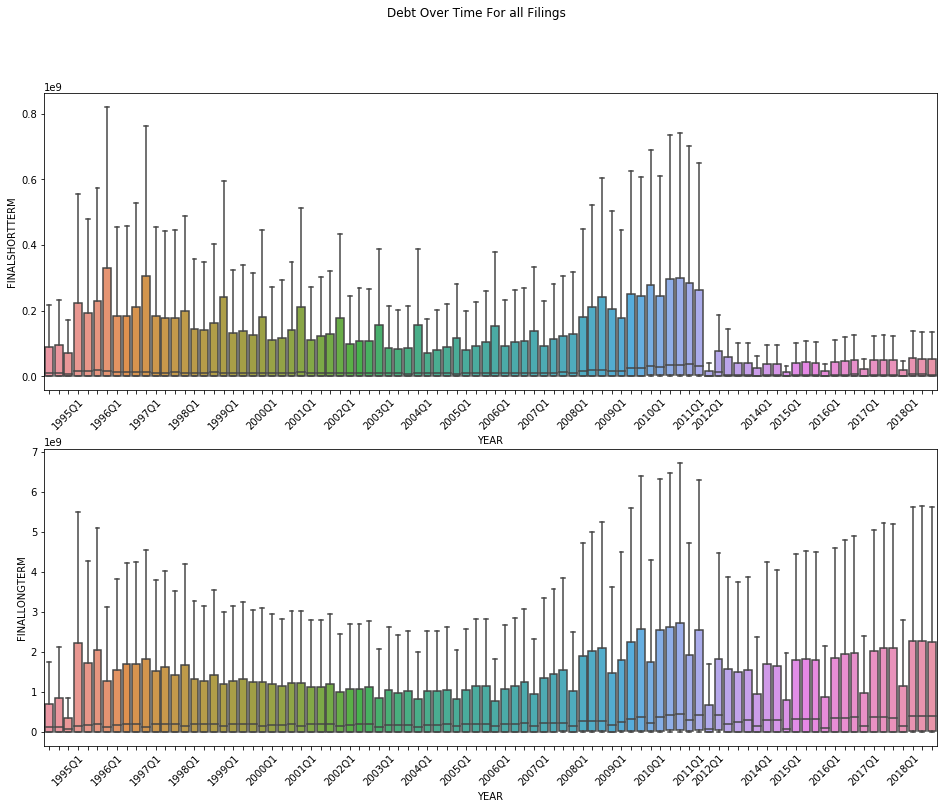

In [16]:
plotData = df[['EXTRACTCODE', 'DATE', 'FINALSHORTTERM', 'FINALLONGTERM']]
plotData = removeLowCountQuarters(plotData)
makeDebtBoxPlot(plotData, "Debt Over Time For all Filings")

## Debt Over Time - Text Filings Only

The chart below is a similiar visualization of the data, however it exclusively includes text-based filings.  The same general orders of magnitude are trends are observed. 

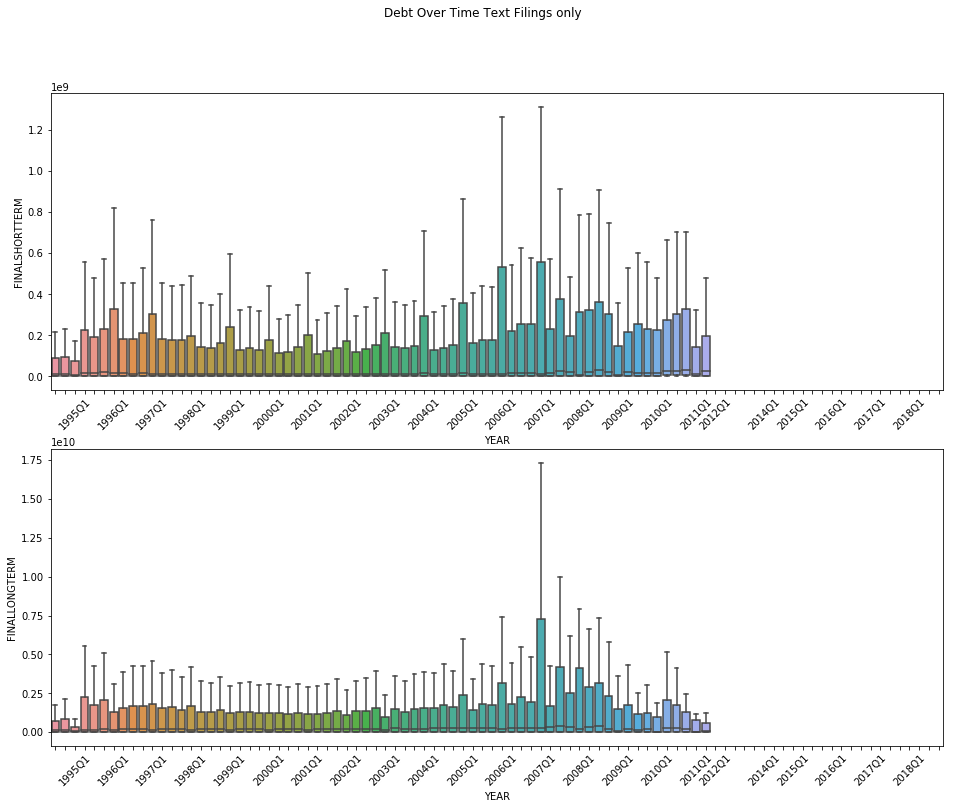

In [17]:
textData = plotData[plotData['EXTRACTCODE'] == 'TEXT']
textData = removeLowCountQuarters(textData)
textData = textData.reindex(plotData.index.values, axis='index')
textData['DATE'] = plotData['DATE']    
makeDebtBoxPlot(textData, "Debt Over Time Text Filings only")

### Debt Over Time HTML Only

It's interesting to compare the results of the HTML visualization with those obtained for XBRL filings.  The HTML short term levels gradually taper off after about 2013, whereas the XBRL short term levels very abruptly and drastically decrease in this time period.  This kind of a sudden change in observed debt levels may be indicative of a change in the XBRL taxonomy used by filers.

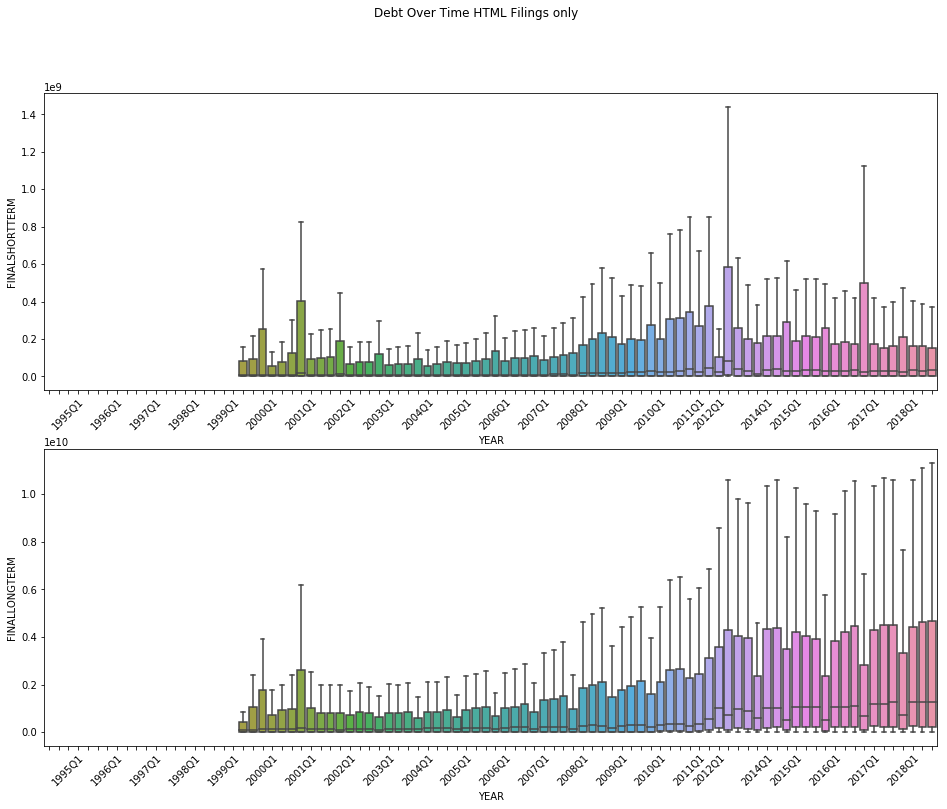

In [18]:
htmlData = plotData[plotData['EXTRACTCODE'] == 'HTML']
htmlData = removeLowCountQuarters(htmlData)
htmlData = htmlData.reindex(plotData.index.values, axis='index')
htmlData['DATE'] = plotData['DATE']    
makeDebtBoxPlot(htmlData, "Debt Over Time HTML Filings only")

### Debt Over Time XBRL Only

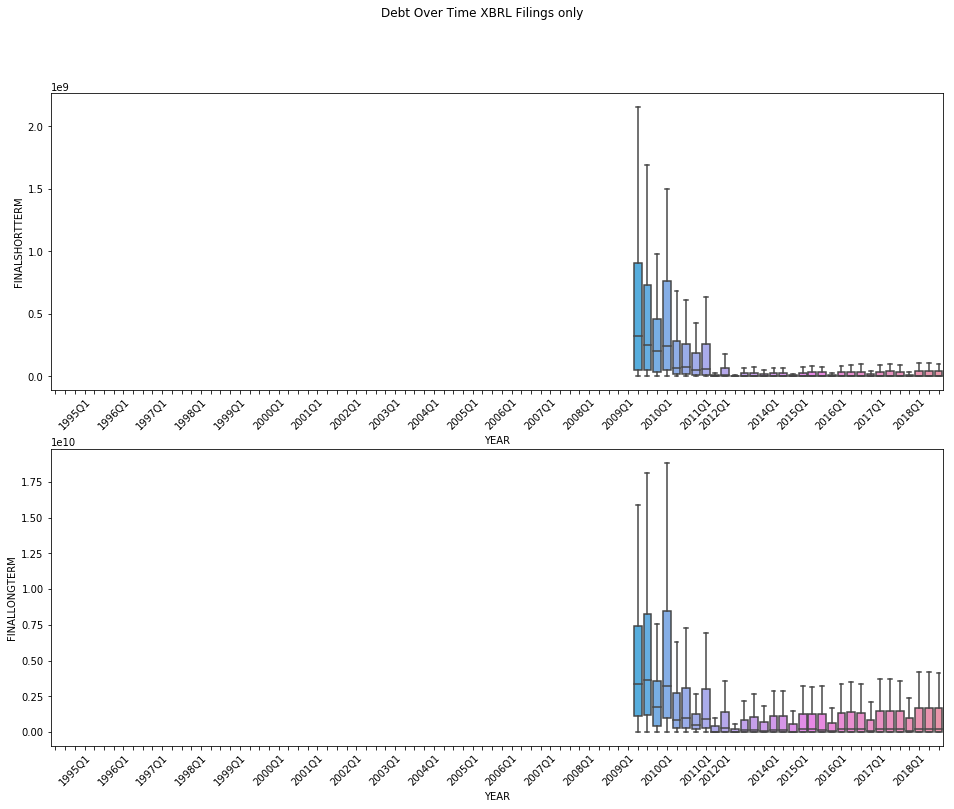

In [19]:
xbrlData = plotData[plotData['EXTRACTCODE'] == 'XBRL']
xbrlData = removeLowCountQuarters(xbrlData)
xbrlData = xbrlData.reindex(plotData.index.values, axis='index')
xbrlData['DATE'] = plotData['DATE']    
makeDebtBoxPlot(xbrlData, "Debt Over Time XBRL Filings only")